<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 5.2 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import pyro
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
import pandas as pd
import numpy as np
from pyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

In [3]:
class ARDRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([in_features]).to_event(1))
        self.one_over_sqrt_alpha = 1/torch.sqrt(self.alpha)

        self.sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
        self.sigma = torch.sqrt(self.sigma2)

        self.linear = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear.weight = PyroSample(dist.Normal(0., self.sigma*self.one_over_sqrt_alpha).expand([out_features, in_features]).to_event(2))

    def forward(self, x, y=None):
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)
        return mean

In [63]:
# Making training data
def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.randn(num_samples).astype(np.float64)
  noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 1

y, x, w = make_training_data(1000, num_features,5, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,20)

In [64]:
y_train.shape

torch.Size([980, 1])

In [65]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO

model = ARDRegression(num_features, 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [66]:
from scipy.stats import norm as NormalDist

pyro.clear_param_store()
num_iterations = 2000
step_ids = []
average_log_predictives = []

mse_loss = nn.MSELoss()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train.squeeze())
    #step_ids.append(j)       

    if j % 100 == 0:
      print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      train_predictions = predictive_svi(x_train, None)
      test_predictions = predictive_svi(x_test, None)
      train_obs = train_predictions['obs']
      test_obs = test_predictions['obs']
      mse_loss(torch.tensor(train_obs), torch.tile(np.squeeze(y_train), (num_samples, 1)))
      average_train_log_mse = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
      average_test_log_mse = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
    
      print(average_train_log_mse)
      print(average_test_log_mse)

      step_ids.append(j)
      average_log_predictives.append(average_test_log_mse)

[iteration 0001] loss: 2.8714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(3.2502)
tensor(2.9641)
[iteration 0101] loss: 2.1919
tensor(2.4857)
tensor(2.4422)
[iteration 0201] loss: 2.0831
tensor(2.3076)
tensor(2.2712)
[iteration 0301] loss: 2.0766
tensor(2.3131)
tensor(2.2901)
[iteration 0401] loss: 2.0762
tensor(2.3067)
tensor(2.3439)
[iteration 0501] loss: 2.0762
tensor(2.2989)
tensor(2.3135)
[iteration 0601] loss: 2.0761
tensor(2.3071)
tensor(2.3480)
[iteration 0701] loss: 2.0761
tensor(2.3031)
tensor(2.2762)
[iteration 0801] loss: 2.0758
tensor(2.3085)
tensor(2.2772)
[iteration 0901] loss: 2.0760
tensor(2.3069)
tensor(2.3335)
[iteration 1001] loss: 2.0764
tensor(2.3060)
tensor(2.2384)
[iteration 1101] loss: 2.0762
tensor(2.2986)
tensor(2.2745)
[iteration 1201] loss: 2.0761
tensor(2.2979)
tensor(2.3458)
[iteration 1301] loss: 2.0759
tensor(2.2987)
tensor(2.3138)
[iteration 1401] loss: 2.0759
tensor(2.2986)
tensor(2.3821)
[iteration 1501] loss: 2.0761
tensor(2.3042)
tensor(2.3047)
[iteration 1601] loss: 2.0760
tensor(2.3080)
tensor(2.3396)
[iteration

In [67]:
NormalDist(0,1).pdf(0)

0.3989422804014327

Text(0, 0.5, 'Average log predictive MSE')

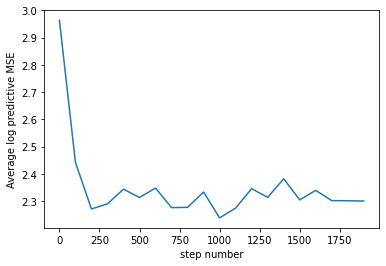

In [68]:
plt.plot(step_ids, average_log_predictives)
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")

In [69]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([1.1054])
AutoDiagonalNormal.scale tensor([0.0967])


In [70]:
print('Actual value of w: {}'.format(w))
print('Fitted median of posterior: {}'.format(guide.quantiles([0.5])))

Actual value of w: [[1.11295366]]
Fitted median of posterior: {'linear.weight': tensor([[[1.1054]]])}


In [71]:
guide.quantiles([0.5])

{'linear.weight': tensor([[[1.1054]]])}

In [73]:
from pyro.infer import MCMC, NUTS, HMC
nuts_kernel = NUTS(model, jit_compile=False, step_size=0.5)
num_samples = 200

mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=100,
    num_chains=1,
)


mcmc_step_ids = []
mcmc_average_test_log_accuracy = []

mse_loss = torch.nn.MSELoss()

for i in range(10):

  mcmc.run(x_train, y_train)
  #mcmc.summary(prob=0.5)
  #diagnostics = mcmc.diagnostics()

  samples = mcmc.get_samples()
  mcmc_predictive = Predictive(model, samples)
  
  test_obs = mcmc_predictive(x_test, None)['obs']
  train_obs = mcmc_predictive(x_train, None)['obs']


  average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
  average_train_log_accuracy = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
  print(average_train_log_accuracy)
  print(average_test_log_accuracy)
  mcmc_step_ids.append(i*num_samples)
  mcmc_average_test_log_accuracy.append(average_test_log_accuracy)

Sample: 100%|██████████| 300/300 [00:16, 18.37it/s, step size=3.15e-01, acc. prob=0.933]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 5.7790, -2.3596,  2.4528,  4.0731,  3.7928,  2.1768,  0.7056, -0.6581,
         1.1168,  6.3091, -4.0413,  0.9645,  1.8812, -2.0076, -1.3432, -8.0277,
        -2.3563,  1.4965, -3.1845,  0.3554])
tensor([-0.9874])
tensor([-1.9921e+00, -2.2915e+00,  5.0431e+00, -4.3455e+00, -5.5570e+00,
         1.0154e+00,  2.5206e+00,  5.1860e-01,  4.8720e+00, -3.5553e+00,
        -7.7492e+00, -1.6783e+00,  3.5016e+00,  5.7090e+00, -3.3400e+00,
        -6.2700e+00,  3.7675e+00, -2.7536e+00,  4.1815e+00,  2.9536e+00,
         2.9930e+00, -4.8015e-01,  1.3399e+00,  3.9311e-03, -4.3032e-02,
         5.8733e+00, -1.1438e+00,  5.4574e+00,  5.5729e+00,  7.5692e-02,
        -1.4175e+00, -2.1137e+00,  1.6076e+00,  5.0823e+00,  7.5732e-01,
         5.1280e+00, -1.3239e+00, -6.1013e+00,  4.8117e+00, -1.7731e+00,
         6.0463e-01,  3.1

Sample: 100%|██████████| 300/300 [00:11, 25.10it/s, step size=4.00e-01, acc. prob=0.912]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 0.6337, -2.3689,  6.3120, -1.2229,  1.1992,  0.4674,  0.2719,  1.1965,
        -3.6382, -1.8282,  2.5291,  3.8670, -4.7679,  1.2839,  0.2597,  0.4708,
         2.1980,  0.7712,  2.7978,  1.7040])
tensor([-0.9874])
tensor([-6.4189, -5.0482,  1.2223, -0.3589, -1.5239,  0.4705,  0.4645, -0.0382,
        -2.2101, -3.3518, -2.6096,  1.5094,  2.9020, -2.2611, -1.6247, -4.4908,
         1.3951, -1.4424, -1.1378,  4.1770, -1.4193,  2.1599, -0.0925,  3.0111,
         2.4758, -1.1425,  1.5682,  4.2480,  1.5700, -1.5269,  5.6508, -1.3409,
        -1.3817,  5.2472, -2.7280, -3.6989, -0.7346, -1.6182, -1.4456,  0.1289,
         1.2122,  6.6544,  3.6350,  2.3781, -2.1345,  1.7516, -4.9528, -0.6192,
         0.0446, -3.2812,  5.0208, -4.3621,  2.7305, -1.6807,  1.7634,  0.3736,
         0.7988, -0.0551,  1.1411,  2.6884, -4.55

Sample: 100%|██████████| 300/300 [00:16, 17.97it/s, step size=3.13e-01, acc. prob=0.942]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([-9.3268, -5.5596,  3.4009,  3.0261, -1.0151,  1.5179, -5.3676, -2.4678,
         5.3764, -0.6883, -1.8611, -1.0254,  2.5861, -0.9085, -0.8177, -2.3539,
         0.3197,  1.2125, -0.2752, -1.3900])
tensor([-0.9874])
tensor([-9.2505e-01,  1.8590e+00, -2.3475e+00,  1.8689e-01, -3.7051e-01,
         3.9640e+00,  9.5985e-01,  4.9283e-01,  5.2793e-01, -9.7560e-01,
        -5.7092e-01,  5.9757e+00,  5.6490e+00,  8.2622e-01,  4.0989e+00,
        -8.7117e-01,  6.3740e-01, -2.2924e+00, -2.1430e-01, -7.3692e+00,
        -3.5171e-01,  1.5732e-01, -8.2170e-01, -4.1816e-01, -2.5206e+00,
         4.5160e+00, -2.7387e-01,  1.8603e+00,  6.4342e+00, -2.1844e+00,
        -2.4959e-01,  2.5301e+00, -2.7174e+00,  1.9197e+00,  1.4748e+00,
        -3.1234e+00, -5.1466e+00,  6.1659e-01, -2.5563e+00,  4.0503e+00,
         2.4488e+00, -3.9

Sample: 100%|██████████| 300/300 [00:17, 17.12it/s, step size=2.71e-01, acc. prob=0.937]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 0.7157,  6.6180,  3.1192, -2.4851, -0.5406, -4.3559,  0.1630,  1.5344,
         0.1125,  1.1303, -5.5715,  1.9054,  3.2158,  4.6152, -1.2663,  4.8153,
         2.7212, -1.4468,  3.0400,  0.3406])
tensor([-0.9874])
tensor([-7.6755e-01, -2.2938e+00, -1.0647e+00, -3.5011e+00, -6.6916e+00,
         6.8103e+00, -8.1368e-01, -4.5777e+00, -2.9560e+00, -5.4774e+00,
        -8.4087e+00, -1.8602e+00, -1.9259e+00, -2.1589e-01,  1.3955e+00,
         1.6206e+00,  3.4051e+00, -2.7277e+00, -1.7262e-01,  1.0798e+00,
         2.1154e+00, -1.8877e-01,  1.9839e+00,  3.0084e+00,  6.8981e+00,
         7.7116e+00,  6.1673e+00, -5.6403e+00,  1.3587e+00,  2.2961e+00,
        -1.2220e+00,  2.3366e+00, -2.6107e+00,  7.1115e+00, -2.8678e+00,
         9.1561e-01,  7.3123e-01,  5.3870e-01,  5.9890e+00,  2.4154e+00,
         4.8169e+00,  8.8

Sample: 100%|██████████| 300/300 [00:12, 24.69it/s, step size=4.36e-01, acc. prob=0.893]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([-0.9532,  0.3353,  3.2794, -3.0850,  1.0247,  0.3174,  0.1897, -5.7140,
         4.8197, -4.0353, -4.2451, -5.2946,  3.2495, -1.4796, -4.8042,  2.8893,
         0.1611,  1.7904,  1.6832,  2.5333])
tensor([-0.9874])
tensor([ 6.9912e-02, -1.9073e+00, -3.6379e+00,  1.9735e+00,  2.7049e+00,
         1.0298e+00,  1.0381e+00,  2.3930e+00, -6.4048e-01, -1.1266e+00,
         1.7652e+00, -5.1784e+00,  5.3454e+00,  7.9298e-02, -7.7680e+00,
        -2.1283e+00,  4.6188e+00,  6.8541e-01,  1.8748e+00,  4.9897e-01,
         1.3912e+00,  2.7365e+00,  8.9194e-01, -6.6948e+00,  2.1435e+00,
         2.3693e+00,  3.4618e+00, -3.5145e+00,  4.7016e+00, -1.4639e+00,
        -3.5544e+00,  1.3382e+00, -4.5767e+00,  2.2053e+00,  1.2733e+00,
        -6.9273e-01, -2.9944e-01,  4.4649e-01,  1.1540e+00,  1.9800e+00,
        -2.7058e+00, -3.6

Sample: 100%|██████████| 300/300 [00:14, 20.82it/s, step size=3.37e-01, acc. prob=0.917]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 3.1907, -0.0108, -0.6346,  2.5013, -1.7812,  2.0375, -2.6953,  0.5976,
        -1.3316,  1.9795,  6.6682,  3.9947,  1.2303,  0.9324,  5.6977,  0.9777,
         2.9478, -0.4919,  3.1811, -0.1170])
tensor([-0.9874])
tensor([-1.6999e+00,  1.0466e+00,  5.4149e+00, -2.5344e+00, -4.6137e+00,
        -6.1413e+00,  8.2094e+00, -3.3150e+00,  2.1023e+00,  1.2701e+00,
        -3.4925e+00,  5.0763e+00,  3.9300e+00, -1.4247e+00,  3.9193e+00,
         4.0933e+00,  2.3942e+00, -5.3223e+00, -5.5548e+00, -9.5286e+00,
        -4.8826e+00, -2.6575e+00,  2.4655e-01,  2.7333e+00,  1.9828e-01,
        -6.6115e+00, -1.8960e+00,  4.7680e+00,  2.2169e+00,  7.7217e+00,
        -9.9094e-01, -2.1889e+00,  2.9685e+00,  2.0080e+00,  1.8138e+00,
         3.8190e+00,  5.0389e+00,  5.9855e+00, -8.7219e-02,  1.7822e+00,
         6.6484e+00, -5.8

Sample: 100%|██████████| 300/300 [00:11, 25.45it/s, step size=3.67e-01, acc. prob=0.924]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 6.7169e-01, -2.7691e+00,  2.0960e+00,  3.2577e+00,  4.2989e-03,
         2.6410e+00, -1.4052e+00,  4.3507e-01, -1.6283e+00,  4.9573e+00,
         1.1823e+00, -9.3325e-01,  1.3731e+00, -3.2554e+00,  4.0428e+00,
        -4.1663e+00,  1.5580e+00,  2.8262e-01,  2.4534e+00, -1.7798e+00])
tensor([-0.9874])
tensor([-3.6011e+00, -3.1620e-01,  1.6591e+00, -4.0697e+00,  1.2943e+00,
         6.2763e+00,  1.2803e+00, -1.1758e+00, -3.1472e+00, -1.2317e+00,
        -2.9881e-01,  5.1872e+00, -4.2209e+00,  4.1266e+00,  2.4627e+00,
         3.0715e+00, -6.6465e+00,  1.3219e+00,  5.1927e+00,  3.2166e-01,
         2.4046e+00, -2.7767e+00,  3.7935e+00, -7.9107e-01,  3.0786e+00,
         5.7377e-01, -1.1066e+00,  1.4363e+00,  4.2318e+00, -3.2092e+00,
        -1.5989e+00,  5.9564e-01, -2.2945e-01,  5.4179e+00, -3.0820e+00,
        -3

Sample: 100%|██████████| 300/300 [00:13, 22.07it/s, step size=4.22e-01, acc. prob=0.900]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([-0.8577, -4.4406,  1.8209,  2.3337,  4.5378, -2.4165, -4.9755,  1.0003,
         0.0642, -0.8489, -3.8020,  0.2772,  1.9728,  0.8459, -1.0901,  6.0791,
         0.3076,  4.5529,  0.5056, -2.8699])
tensor([-0.9874])
tensor([-3.6500e+00, -2.9255e+00, -1.2676e+00,  4.9103e+00, -1.3288e+00,
        -2.0470e+00,  4.3474e+00,  2.2509e+00,  2.9605e+00,  1.6413e+00,
        -4.4571e+00,  3.6717e+00, -5.6227e+00, -9.2302e-01, -1.2640e+00,
         4.5588e+00,  7.5618e-01,  3.7540e+00,  2.1363e-02, -4.4427e-01,
         3.1211e+00, -3.8241e+00,  2.0000e+00, -6.4518e-03, -2.8514e+00,
         6.2423e-01,  9.6184e-01, -1.1239e+00, -8.1823e-01,  2.5207e+00,
         8.4104e-01,  2.2831e+00,  3.3722e+00, -1.3369e-02,  1.2141e+00,
        -1.8093e+00,  6.6884e-01,  8.9270e+00,  8.7110e-01,  1.3503e+00,
        -3.6911e+00,  4.3

Sample: 100%|██████████| 300/300 [00:22, 13.40it/s, step size=2.80e-01, acc. prob=0.955]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 5.6063, -1.7881,  1.5593, -3.9123, -2.4704,  0.5071, -0.2818, -0.6712,
        -0.7301, -1.5583,  4.0918,  0.4711, -4.2183,  0.1462,  0.8257,  1.8225,
        -2.3824,  3.6269,  0.3484, -0.2492])
tensor([-0.9874])
tensor([-1.6469e+00, -2.4646e+00, -1.0930e-01, -6.4223e-01,  1.0405e+00,
        -1.0013e+00, -4.9131e+00,  9.8763e-01, -2.6738e-01,  6.3186e+00,
        -9.8390e+00, -1.1251e+00, -5.1486e+00, -1.2970e-01,  3.5013e+00,
         3.9369e+00,  4.8174e+00,  3.4770e+00,  5.4407e+00,  7.8808e+00,
         2.0400e-01,  5.6117e+00, -5.7396e+00, -2.4260e+00,  1.2424e+00,
         5.9019e+00, -2.2576e+00, -5.6968e+00,  5.0570e+00,  8.7272e-01,
        -2.5650e+00,  1.8037e+00, -6.6220e+00, -3.3899e-02, -2.8954e+00,
        -7.0041e+00, -5.5745e-01,  9.3601e-02,  5.1262e-01,  1.7438e-01,
         6.5505e-01, -7.1

Sample: 100%|██████████| 300/300 [00:12, 24.78it/s, step size=4.16e-01, acc. prob=0.902]


{'linear.weight': OrderedDict([('n_eff', tensor([[107.6428]])), ('r_hat', tensor([[1.0261]]))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 0.935}}
tensor([ 2.6677, -2.1723,  0.1333,  4.9978, -2.2745,  5.1214,  1.5165,  0.7268,
         4.0801, -0.3842, -3.1468, -1.7869, -0.4016, -1.7000, -0.0681,  0.3024,
         1.1385, -0.6726,  8.2016, -5.0648])
tensor([-0.9874])
tensor([-4.5269e+00, -5.0395e-01, -1.1489e+00,  1.5172e+00,  5.1027e+00,
        -2.9486e+00, -1.5170e+00,  6.2056e+00, -2.8390e+00,  4.2096e+00,
        -1.7281e+00, -3.4588e+00, -8.0975e+00,  1.9044e+00,  2.4212e+00,
        -2.7293e+00,  1.2228e+00,  4.9846e-01,  8.1717e+00,  2.1234e+00,
         2.0561e+00,  1.8218e+00, -8.3949e-01, -6.1149e+00,  1.4499e+00,
        -6.7459e+00, -2.2825e+00,  2.9216e+00, -4.0895e+00, -1.3770e+00,
         4.3982e+00,  5.4351e+00,  1.0252e+00, -2.9397e+00,  5.1137e+00,
         4.4922e+00,  1.9565e+00, -2.0069e+00, -8.6622e-01, -1.3449e-01,
        -3.0963e+00,  2.3

Text(0, 0.5, 'Average log predictive MSE')

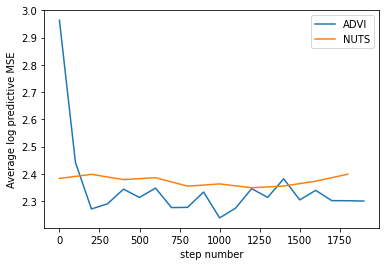

In [74]:
plt.plot(step_ids, average_log_predictives, label='ADVI')
plt.plot(mcmc_step_ids, mcmc_average_test_log_accuracy, label='NUTS')
plt.legend()
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")
